In [4]:
# import all libraries 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import json



In [5]:
#read xml and get important items

def read_content(xml_file: str):
    
    #open XML
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_names = []
    list_with_image_dimentions=[]
    
    #get inmportant information from XML
    for boxes in root.iter("object"):

        file_name = root.find("filename").text
        file_path = root.find("path").text
        name = boxes.find("name").text
        width = int(root.find("size").find("width").text)
        height= int(root.find("size").find("height").text)

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)


        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
        list_with_all_names.append(name)
        list_with_image_dimentions.append([width,height])
        

    return file_path,file_name, list_with_all_boxes,list_with_all_names,list_with_image_dimentions

In [19]:
#create csv file with metadata or read csv with metadata 

def create_and_read_metadata(images_path , medata_path, split_value , labels_dic):

    """
    Returns Dataframe with all data

    Args:
        initial_path (str): path of the xml and img you want to read.

        split (int): value between 0 and 1 .

        labels_dic (dic): Dictionary with the labels.
    Returns:
        metadata (df): Dataframe with all data .

    """

    if os.path.isfile(os.path.join(medata_path,'metadata.csv'))==False:

        w=[]
        for file in os.listdir(images_path):
            if file.endswith(".xml"):
                w.append(read_content(os.path.join(images_path,file)))


        names,splits,labl,xmin,xmax,ymin,ymax=[],[],[],[],[],[],[]

        for i in w:

            #split images in train and test
            split = np.random.rand(1)[0]
            if split< split_value:
                spl='train'
            else:
                spl='test'

            #create metadata columns
            splits.append(spl)
            labl.append(i[3][0])
            ymin.append(i[2][0][1]/i[4][0][1])
            ymax.append(i[2][0][3]/i[4][0][1])
            xmin.append(i[2][0][0]/i[4][0][0])
            xmax.append(i[2][0][2]/i[4][0][0])
            names.append(i[1])

        #generate dictionary to build csv
        df={}
        df["names"]=names
        df["xmin"]=xmin
        df["xmax"]=xmax
        df["ymin"]=ymin
        df["ymax"]=ymax
        df['split']=splits
        df['label']=labl
        df = pd.DataFrame(df)
        df=df.replace(labels_dic)

        #create csv with metadata information
        df.to_csv(os.path.join(medata_path,'metadata.csv'), index=False)
        metadata=df
    else:
        metadata = pd.read_csv(os.path.join(medata_path,'metadata.csv'))

    return metadata

In [26]:
#function to separate train and test images

def build_sources_from_metadata(metadata, data_dir, mode='train', exclude_labels=None): 
    
    if exclude_labels is None:
        exclude_labels = set()
    if isinstance(exclude_labels, (list, tuple)):
        exclude_labels = set(exclude_labels)

    df = metadata.copy()
    df = df[df['split'] == mode]
    df['filepath'] = df['names'].apply(lambda x: os.path.join(data_dir, x))
    include_mask = df['label'].apply(lambda x: x not in exclude_labels)
    df = df[include_mask]

    sources = list(zip(df['filepath'], zip(df["xmin"],df["xmax"],df["ymin"],df["ymax"]),df['label']))
    return sources

In [27]:
#create metadata nad read it
dic = {"Formato_1": 1, "Formato_2": 2, "Formato_3": 3}
metadata = create_and_read_metadata('local\data\imgs' , 'local\data', 0.7 , dic)

In [38]:
#split images in train and test
train_sources = build_sources_from_metadata(metadata, 'local\data\imgs')
test_sources = build_sources_from_metadata(metadata, 'local\data\img',mode='test')

In [39]:
train_sources

[('local\\data\\imgs\\09-22-2020-14.53.24(1).jpg',
  (0.13741636644364386,
   0.2799794132784354,
   0.39487384861834207,
   0.420504605526632),
  1),
 ('local\\data\\imgs\\09-22-2020-14.53.24(10).jpg',
  (0.15344603381014305,
   0.2919375812743823,
   0.3913904007916873,
   0.4151410192973775),
  1),
 ('local\\data\\imgs\\09-22-2020-14.53.24(100).jpg',
  (0.14209274673008326,
   0.296076099881094,
   0.380736029077692,
   0.40663334847796456),
  1),
 ('local\\data\\imgs\\09-22-2020-14.53.24(102).jpg',
  (0.13737373737373734,
   0.2898989898989899,
   0.3724961479198767,
   0.4029275808936826),
  1),
 ('local\\data\\imgs\\09-22-2020-14.53.24(103).jpg',
  (0.15113974231912786,
   0.3230921704658077,
   0.37848324514991183,
   0.4014109347442681),
  1),
 ('local\\data\\imgs\\09-22-2020-14.53.24(104).jpg',
  (0.12890839275918814,
   0.2934722984092156,
   0.3751563151313047,
   0.40850354314297627),
  1),
 ('local\\data\\imgs\\09-22-2020-14.53.24(105).jpg',
  (0.13389121338912133, 0.28332

In [40]:
#function to show a batch of three images

def imshow_batch_of_three(batch, show_box=True):
    boxes_batch = batch[1].numpy()
    image_batch = batch[0].numpy()
    fig, axarr = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    _,len_y,len_x,_=image_batch.shape

    for i in range(3):
        img = image_batch[i, ...]
        axarr[i].imshow(img)
        if show_box:
#             axarr[i].set(xlabel='cordenates = {}'.format(boxes_batch[i]))
            axarr[i].plot((int(boxes_batch[i][0]*len_x),int(boxes_batch[i][1]*len_x)),(int(boxes_batch[i][2]*len_y),int(boxes_batch[i][2]*len_y)),"r")
            axarr[i].plot((int(boxes_batch[i][0]*len_x),int(boxes_batch[i][1]*len_x)),(int(boxes_batch[i][3]*len_y),int(boxes_batch[i][3]*len_y)),"r")
            axarr[i].plot((int(boxes_batch[i][0]*len_x),int(boxes_batch[i][0]*len_x)),(int(boxes_batch[i][2]*len_y),int(boxes_batch[i][3]*len_y)),"r")
            axarr[i].plot((int(boxes_batch[i][1]*len_x),int(boxes_batch[i][1]*len_x)),(int(boxes_batch[i][2]*len_y),int(boxes_batch[i][3]*len_y)),"r")

In [44]:
#preprocessing images 

#reshape images
def preprocess_image(image):
    image = tf.image.resize(image, size=(227,227))
    image = image / 255.0
    return image

def augment_image(image):
    return image



def make_tf_dataset(sources, training=False, batch_size=1,
    num_epochs=1, num_parallel_calls=1, shuffle_buffer_size=None):
    """
    Returns an operation to iterate over the dataset specified in sources

    Args:
        sources (list): A list of (filepath, label_id) pairs.
        training (bool): whether to apply certain processing steps
            defined only in training mode (e.g. shuffle).
        batch_size (int): number of elements the resulting tensor
            should have.
        num_epochs (int): Number of epochs to repeat the dataset.
        num_parallel_calls (int): Number of parallel calls to use in
            map operations.
        shuffle_buffer_size (int): Number of elements from this dataset
            from which the new dataset will sample.

    Returns:
        A tf.data.Dataset object. It will return a tuple images of shape
        [N, H, W, CH] and labels shape [N, 1].
    """
    def load(row):
        filepath = row['image']
        
        #read file
        img = tf.io.read_file(filepath)
        
        #tell TF this is an image jpg
        img = tf.io.decode_jpeg(img)
        
        return img, row['bounding_box']

    if shuffle_buffer_size is None:
        shuffle_buffer_size = batch_size*4

    images, Bounding_Box , labels = zip(*sources)
    
    ds = tf.data.Dataset.from_tensor_slices({
        'image': list(images),'bounding_box' : list(Bounding_Box), 'label': list(labels)}) 
    #line from the link. As with most code, if you remove an arbitrary line, expectin

    #shuffle dataset
    if training:
        ds = ds.shuffle(shuffle_buffer_size)
    #load images 
    ds = ds.map(load, num_parallel_calls=num_parallel_calls)
    
    #preprocces images
    ds = ds.map(lambda x,y: (preprocess_image(x), y), num_parallel_calls=num_parallel_calls)
    
    #data aumentation
    if training:
        ds = ds.map(lambda x,y: (augment_image(x), y))
        
    #repeat this order num_epochs times        
    ds = ds.repeat(count=num_epochs)
    #set size of the batch to return
    ds = ds.batch(batch_size=batch_size)
    #pre load x times of baches
    ds = ds.prefetch(1)

    return ds

In [45]:
import tensorflow as tf

In [46]:

dataset = make_tf_dataset(train_sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)
dataset = iter(dataset)


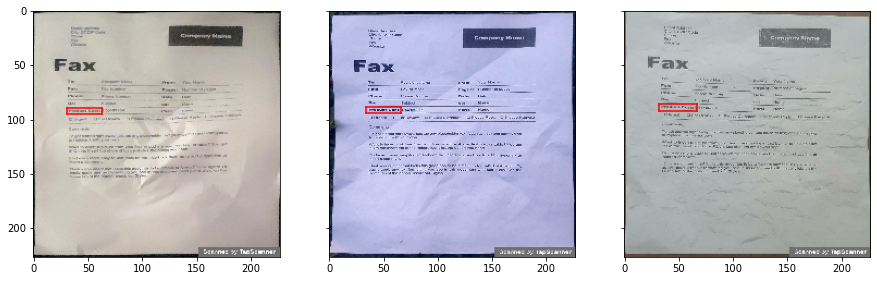

In [47]:
imshow_batch_of_three(next(dataset))

In [14]:
#leNet

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(227,227,3)))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=120, activation='tanh'))

model.add(tf.keras.layers.Dense(units=84, activation='tanh'))

model.add(tf.keras.layers.Dense(units=4, activation = 'sigmoid'))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.optimizers.Adam(0.0001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 44944)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               5393400   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [16]:
dataset = make_dataset(train_sources, training=True,
    batch_size=4, num_epochs=1,
    num_parallel_calls=2)

testset = make_dataset(test_sources, training=True,
    batch_size=1, num_epochs=1,
    num_parallel_calls=2)

In [20]:
#evaluate dataset with the CNN not entrened
print(model.evaluate(dataset))

89/89 [==============================] - 12s 138ms/step - loss: 0.6907 - accuracy: 0.0078
[0.6907197712512498, 0.0077683614]


In [22]:
h=model.fit(x=dataset, epochs=10,validation_data=testset, validation_steps=1)

Train for 89 steps, validate for 1 steps
Epoch 1/10
89/89 [==============================] - 11s 121ms/step - loss: 0.5734 - accuracy: 0.0078 - val_loss: 0.6436 - val_accuracy: 0.0000e+00
Epoch 2/10
89/89 [==============================] - 11s 126ms/step - loss: 0.5738 - accuracy: 0.0078 - val_loss: 0.7139 - val_accuracy: 0.0000e+00
Epoch 3/10
89/89 [==============================] - 11s 124ms/step - loss: 0.5740 - accuracy: 0.0078 - val_loss: 0.6528 - val_accuracy: 0.0000e+00
Epoch 4/10
89/89 [==============================] - 11s 127ms/step - loss: 0.5711 - accuracy: 0.0078 - val_loss: 0.6467 - val_accuracy: 0.0000e+00
Epoch 5/10
89/89 [==============================] - 11s 125ms/step - loss: 0.5702 - accuracy: 0.0078 - val_loss: 0.6482 - val_accuracy: 0.0000e+00
Epoch 6/10
89/89 [==============================] - 12s 130ms/step - loss: 0.5689 - accuracy: 0.0078 - val_loss: 0.6361 - val_accuracy: 0.0000e+00
Epoch 7/10
89/89 [==============================] - 15s 163ms/step - loss: 0.

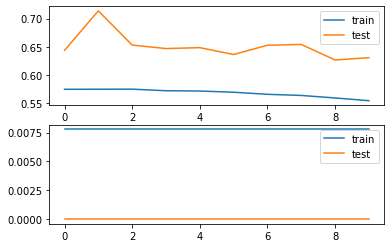

In [23]:

plt.subplot(2,1,1)
plt.plot(h.history['loss'],label='train')
plt.plot(h.history['val_loss'],label='test')
plt.legend()
plt.subplot(2,1,2)
plt.plot(h.history['accuracy'],label='train')
plt.plot(h.history['val_accuracy'],label='test')
plt.legend()


In [48]:
from local.lib import load_data

SyntaxError: non-default argument follows default argument (load_data.py, line 58)